In [1]:
#import libraries
import numpy as np
import pandas as pd
import sys
import math
import matplotlib.pyplot as plt
import random
from scipy.stats import chisquare

In [2]:
def benford_x_digit(rawdata,digit):
    data_nonzero=filter(lambda n: n !=0. , rawdata)
    data=list(data_nonzero)
    BFD= [math.log10(1.0+1.0/n) for n in range (10**(digit-1),10**digit)]
    data_count={}
    for i in range(10**(digit-1),10**digit):
        data_count[i]=0      
    data_xdigits=[int(str(abs(x*1000))[0:digit]) for x in data]
    for i in range(len(data_xdigits)):
            data_count[data_xdigits[i]]=data_count[data_xdigits[i]]+1
    list_tuples=sorted(data_count.items())
    data_count=[i[1] for i in list_tuples]
    total_count=sum(data_count)
     
    expected_count=[p * total_count for p in BFD]
    #We are not rounding/flooring here because it may be useful to have the 
    #fractions even if it doesnt make sense in real life, just to reconcile totals
    #in the dataframe wrapper I am rounding it anyway.    
    
    #conveniently, in python a function can return several values, in this case
    #we are returning the data count, expected count and expected frequency for 
    #the first n digits and raw data provided. 
    return  data_count, expected_count, BFD
def benford_x_digit_to_dataframe(rawdata,digit):
    c,e,p = benford_x_digit(data,1)
    return pd.DataFrame(tuple(zip((1,2,3,4,5,6,7,8,9),c,np.around(e),p)),columns=['Digit','Count','Exp_count','Exp_freq'])

#Now a test with dummy data to see how it works without having to load external data
print("Test values:")
data=[0,0,0,0,-1,11,1.11,0.1111,1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,4,4,4,5,5,5,6,6,7,7,8,8,9,9]
# This list should match exactly the expected count, i.e. 11,6,4,3,3,2,2,2,2
benford_x_digit_to_dataframe(data,1)


Test values:


Digit  Count  Exp_count  Exp_freq
0      1     11       11.0  0.301030
1      2      6        6.0  0.176091
2      3      4        4.0  0.124939
3      4      3        3.0  0.096910
4      5      3        3.0  0.079181
5      6      2        2.0  0.066947
6      7      2        2.0  0.057992
7      8      2        2.0  0.051153
8      9      2        2.0  0.045757

In [3]:
def plot_benford(data,digit):   
    data_count, expected_count, p =benford_x_digit(data,digit)
    y1 = expected_count
    y2 = data_count
    x= np.arange(10**(digit-1),10**digit)
    bins = np.linspace(1, 10)
    width=.35
    plt.figure(figsize=(20, 8), dpi=80)
    plt.bar(x, y2, width, label="Actual")
    plt.bar(x+width, y1, width, label="Benford")
    plt.xticks(x+width/2 , x)
    plt.legend(loc='upper right')
    
    plt.show()

In [4]:
df= pd.read_excel("./input/data.xlsx")
df

field1  field2  field3
0         -23     -35      41
1           0      57      19
2         -68  -11178   11234
3          57   -3189    2089
4         -85    4267     705
...       ...     ...     ...
99995      71     393     476
99996     -54    4337     911
99997     111    1108    -780
99998     -42     982     691
99999     -22    -618     992

[100000 rows x 3 columns]

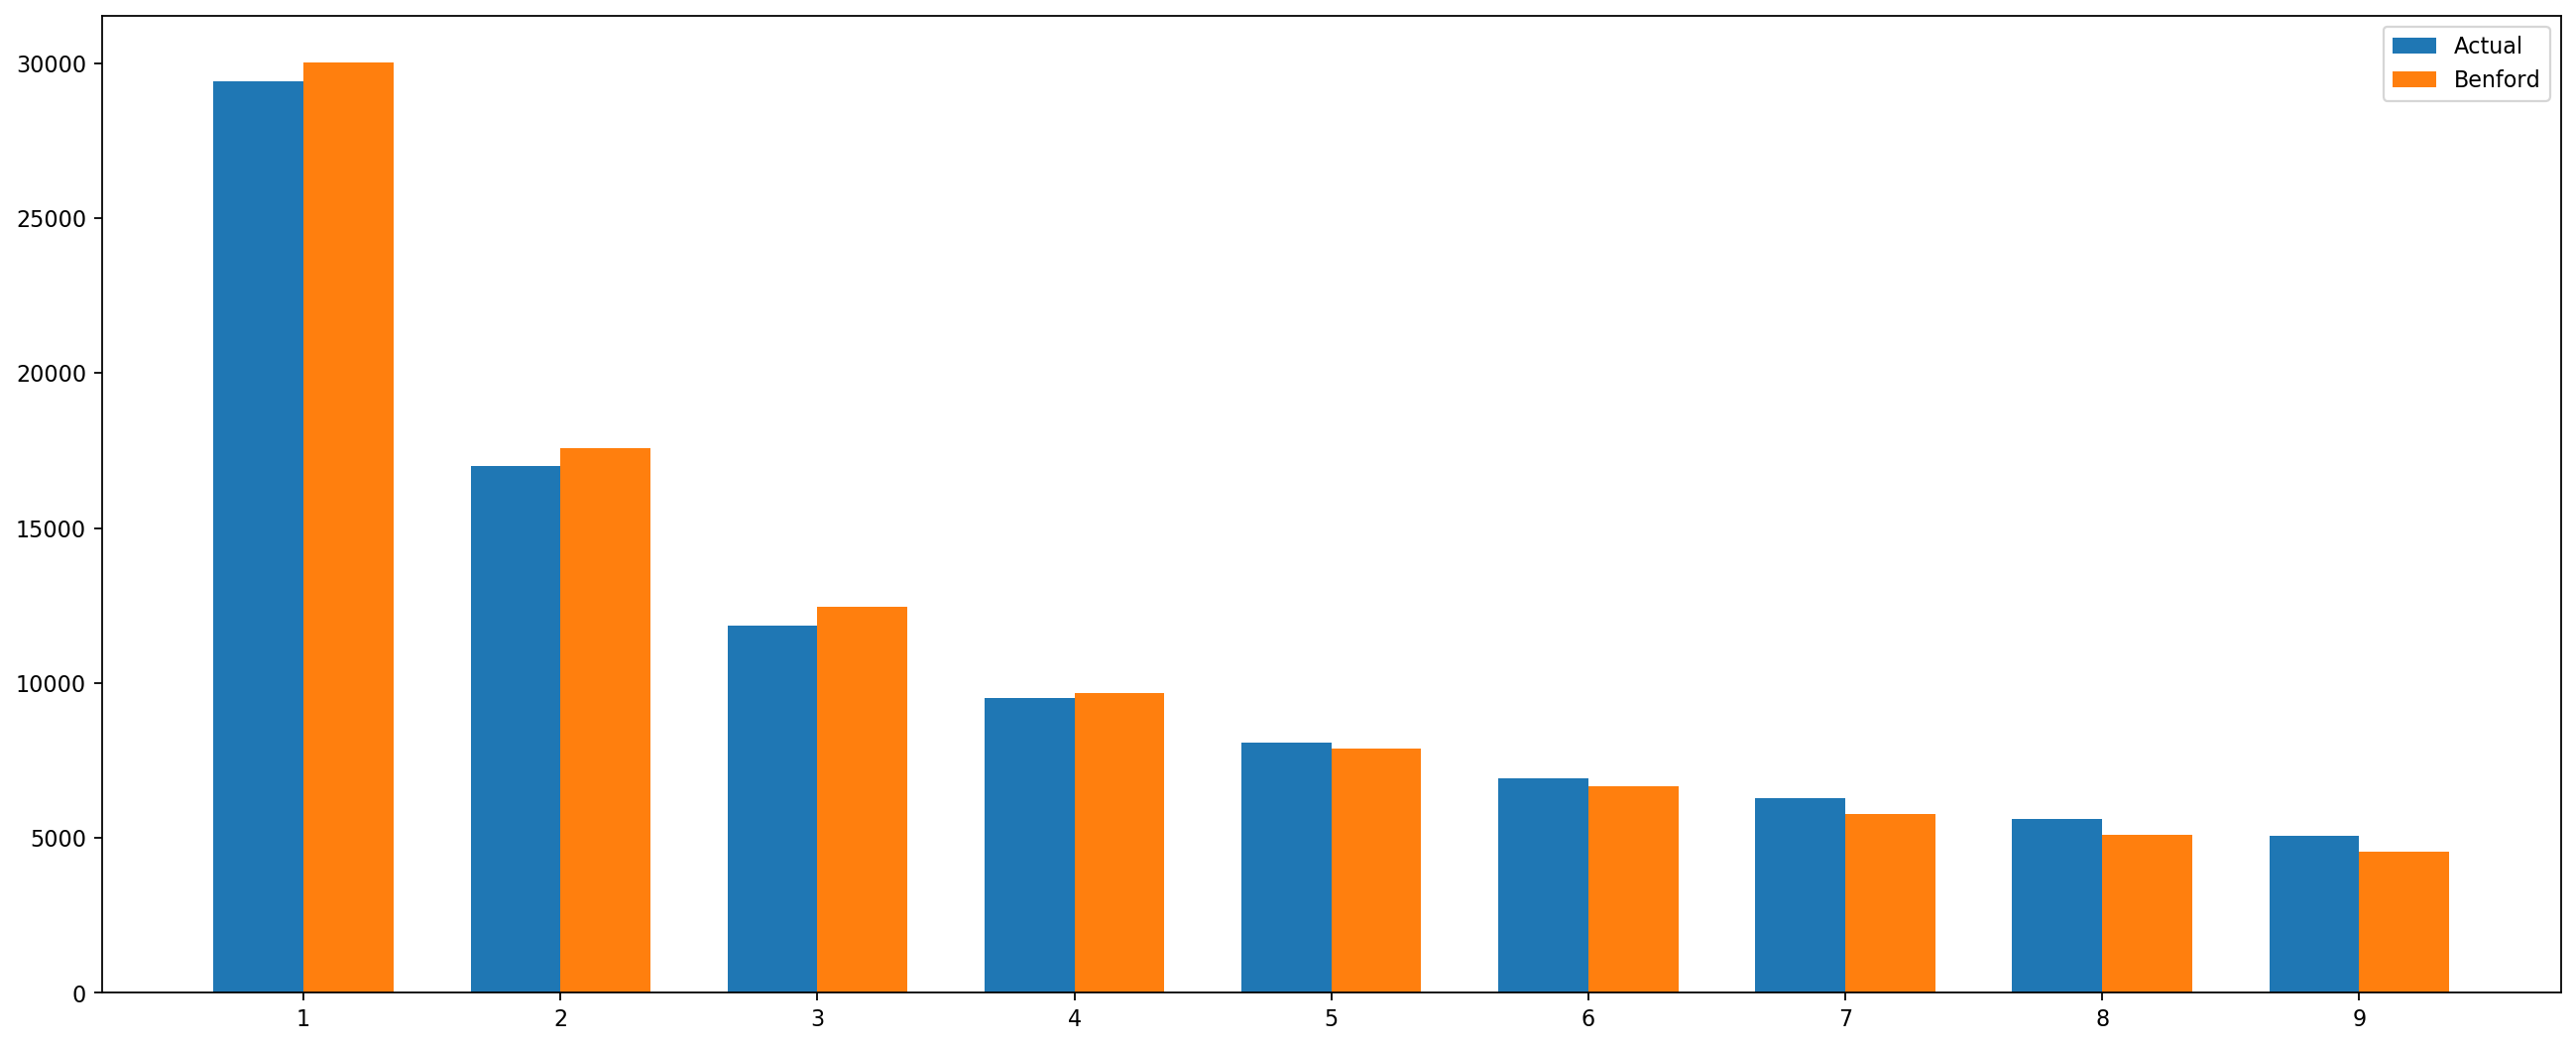

In [5]:
digit=1
data=df["field3"].tolist()
plot_benford(data,digit)

In [6]:
#if we want the actual data
benford_x_digit_to_dataframe(data,1)

Digit  Count  Exp_count  Exp_freq
0      1  29409    30030.0  0.301030
1      2  16989    17566.0  0.176091
2      3  11843    12464.0  0.124939
3      4   9518     9667.0  0.096910
4      5   8083     7899.0  0.079181
5      6   6937     6678.0  0.066947
6      7   6288     5785.0  0.057992
7      8   5617     5103.0  0.051153
8      9   5073     4565.0  0.045757

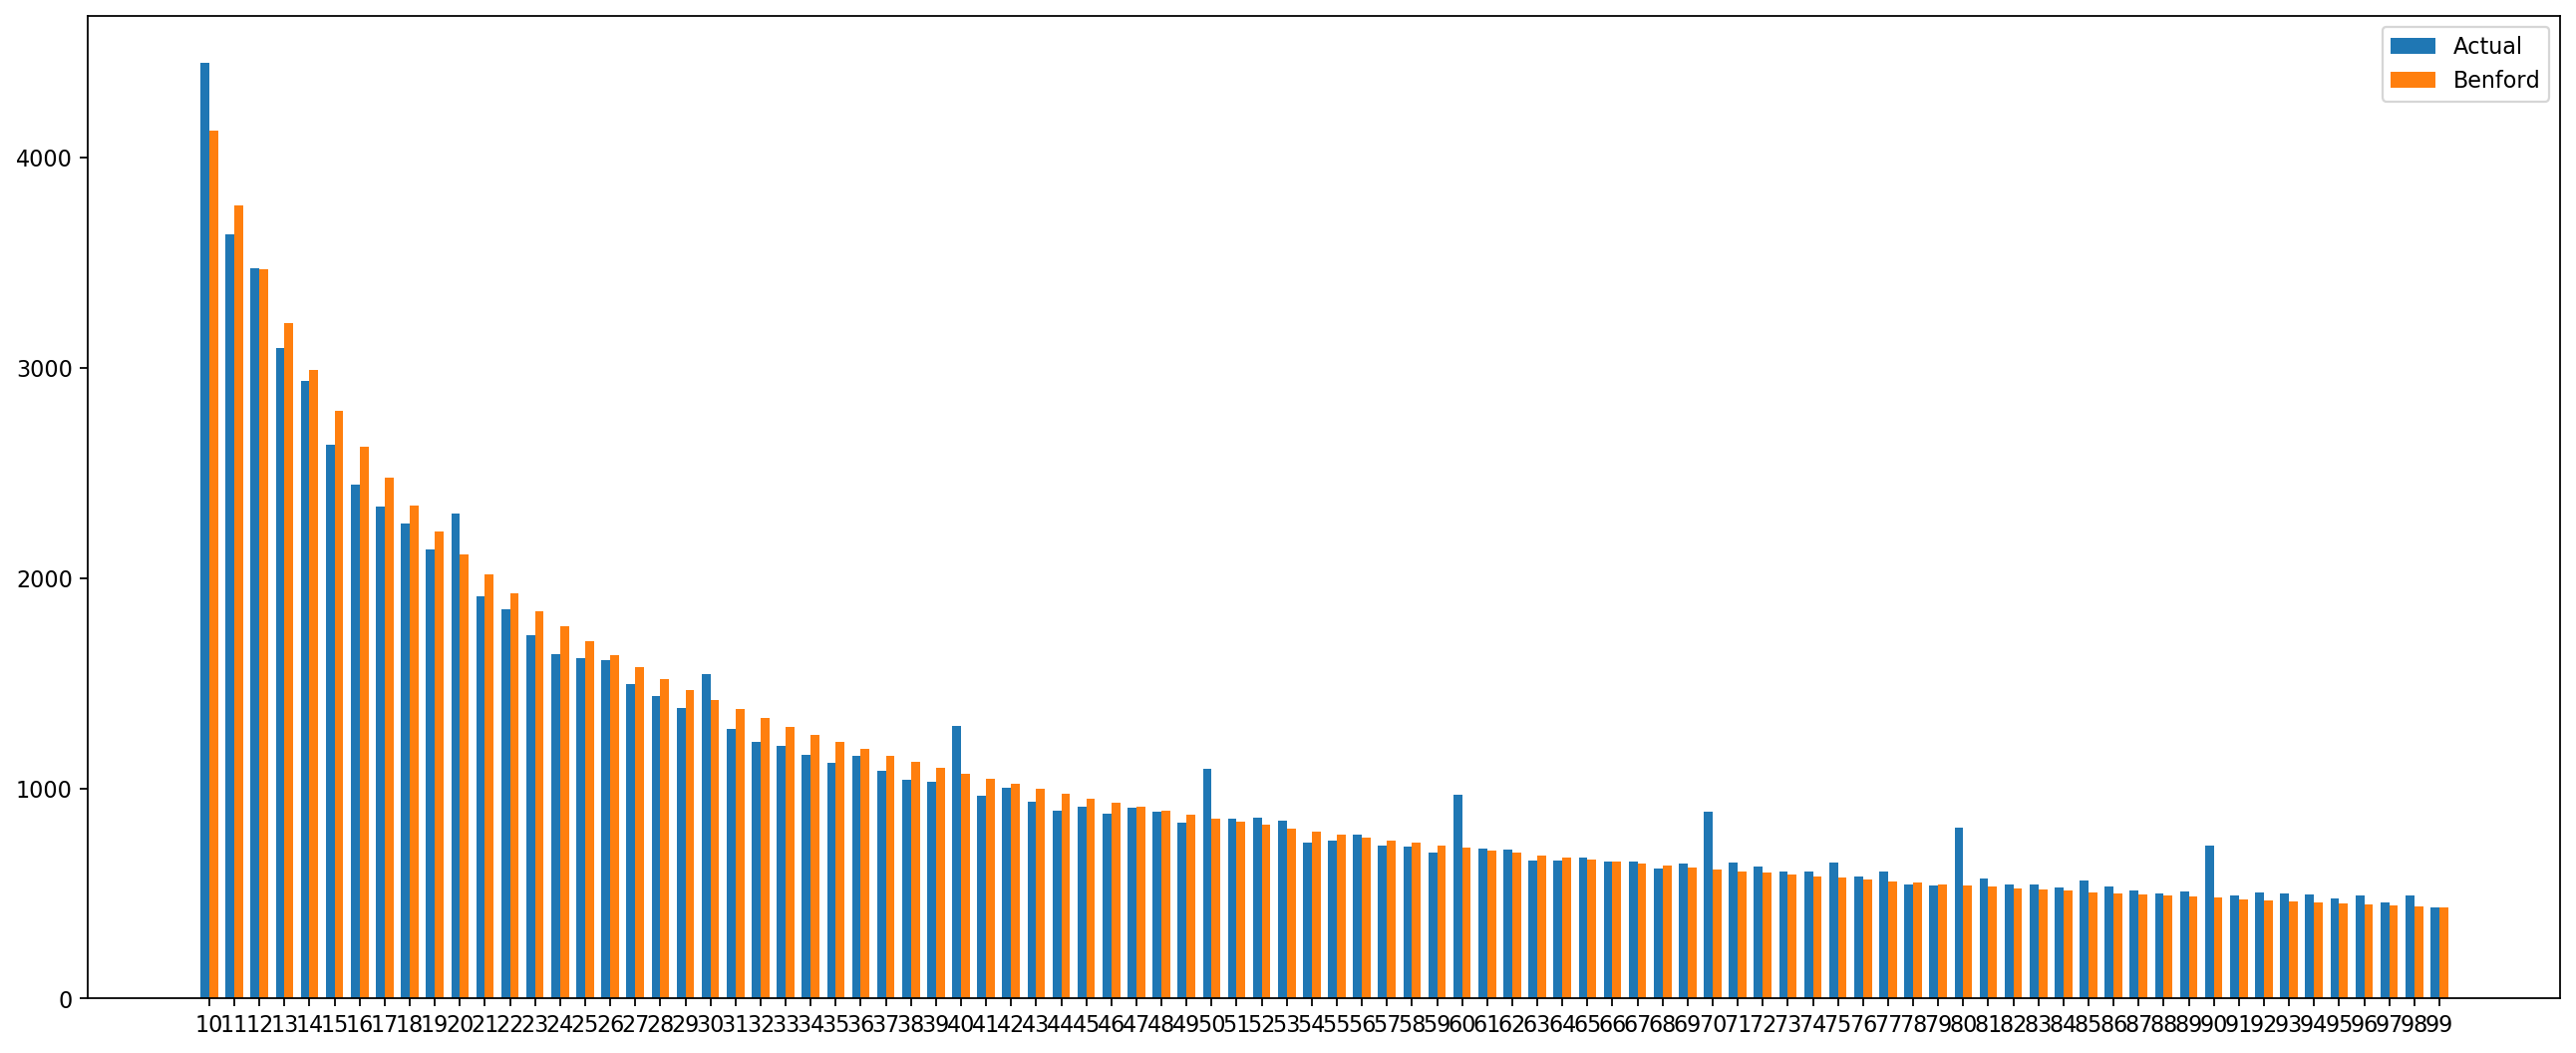

In [7]:
digit=2
data=df["field3"].tolist()
plot_benford(data,digit)

In [8]:
anomalies=[]
digit=2
data_count, expected_count, p =benford_x_digit(data,digit)
for i in range(len(data_count)):
    diff = abs(expected_count[i]-data_count[i])
    diff_perc=abs(diff/expected_count[i])
    anomalies.append([range(10**(digit-1),10**digit)[i],data_count[i],expected_count[i],diff, diff_perc])


In [9]:
df_anomalies=pd.DataFrame(anomalies,columns=["digit","count","expected","diff","diff_perc"])
df_anomalies.sort_values(by="diff", ascending=False)

digit  count     expected        diff  diff_perc
0      10   4451  4129.210093  321.789907   0.077930
70     80    813   538.192196  274.807804   0.510613
60     70    887   614.533915  272.466085   0.443370
50     60    971   716.114067  254.885933   0.355929
80     90    728   478.722160  249.277840   0.520715
..    ...    ...          ...         ...        ...
69     79    539   544.962086    5.962086   0.010940
38     48    888   893.308239    5.308239   0.005942
37     47    907   912.116103    5.116103   0.005609
56     66    652   651.499715    0.500285   0.000768
89     99    435   435.419893    0.419893   0.000964

[90 rows x 5 columns]

This does the Chi Square test, but tends to be problematic with high numbers due to high degrees of freedom, from the documentation you probably can't use it Benford)

In [31]:
def chisquare_test(data_count,digit):
    total_count=sum(data_count)  
    BFD= [math.log10(1.0+1.0/n) for n in range (10**(digit-1),10**digit)]
    exp_count=[int(p * total_count) for p in BFD]      
    chi_sqr, pvalue = chisquare(data_count, f_exp=exp_count) 
    return chi_sqr , pvalue
digit=2
data_count, expected_count, p =benford_x_digit(data,digit)
total_count=sum(data_count)  
data_count
chi_sqr, pvalue = chisquare_test(data_count,digit)
print("CHI square statistic:",chi_sqr)
print("p value",pvalue)


CHI square statistic: 904.1025911196125
p value 4.1636274817654455e-135
